In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

path_data = r"C:\Users\Perydox\Desktop\Proyecto_Grado\data"


In [3]:
atenciones = pd.read_csv(
    os.path.join(path_data, "atenciones.csv"),
    header=None,
    names=['atencion_id','paciente_id','tratamiento_id','fecha','forma_pago','estado_pago','observaciones'],
    parse_dates=['fecha']
)
tratamientos = pd.read_csv(
    os.path.join(path_data, "tratamientos.csv"),
    header=None,
    names=['tratamiento_id','nombre','area_id','precio'],
    dtype={'precio': float}
)
display(atenciones.head(), tratamientos.head())


,atencion_id,paciente_id,tratamiento_id,fecha,forma_pago,estado_pago,observaciones
0,1,319,9,2021-01-01,Efectivo,Pagado,NaN
1,2,319,7,2021-01-01,Efectivo,Pagado,NaN
2,3,112,4,2021-01-01,Efectivo,Pagado,NaN
3,4,39,9,2021-01-01,Efectivo,Pagado,NaN
4,5,338,15,2021-01-01,Efectivo,Pendiente,NaN


,tratamiento_id,nombre,area_id,precio
0,1,Consulta General,1,200.0
1,2,Limpieza Dental,1,250.0
2,3,Tratamiento de Caries,1,400.0
3,4,Colocación de Brackets,2,3000.0
4,5,Mantenimiento de Ortodoncia,2,500.0


In [4]:
df = atenciones.merge(
    tratamientos[['tratamiento_id','precio']],
    on='tratamiento_id', how='left'
)
df['ingreso'] = np.where(df['estado_pago']=="Pagado", df['precio'], 0.0)

df_dia = (
    df.groupby('fecha')['ingreso']
      .sum()
      .reset_index()
      .sort_values('fecha')
)

# Rellenar días faltantes
all_days = pd.date_range(df_dia['fecha'].min(), df_dia['fecha'].max(), freq='D')
df_dia = (
    df_dia.set_index('fecha')
         .reindex(all_days, fill_value=0)
         .rename_axis('fecha')
         .reset_index()
)
display(df_dia.head())


,fecha,ingreso
0,2021-01-01,12500.0
1,2021-01-02,24800.0
2,2021-01-03,6700.0
3,2021-01-04,11960.0
4,2021-01-05,33910.0


In [5]:
df_dia['dow']    = df_dia['fecha'].dt.dayofweek
df_dia['sin_yr'] = np.sin(2*np.pi * df_dia['fecha'].dt.dayofyear / 365)
df_dia['cos_yr'] = np.cos(2*np.pi * df_dia['fecha'].dt.dayofyear / 365)
df_dia['sin_wk'] = np.sin(2*np.pi * df_dia['dow'] / 7)
df_dia['cos_wk'] = np.cos(2*np.pi * df_dia['dow'] / 7)

df_dia['lag1'] = df_dia['ingreso'].shift(1)
df_dia['ma7']  = df_dia['ingreso'].rolling(7).mean().shift(1)
df_dia['ma30'] = df_dia['ingreso'].rolling(30).mean().shift(1)

for c in ['lag1','ma7','ma30']:
    df_dia[c].fillna(df_dia[c].mean(), inplace=True)

display(df_dia.tail())


C:\Users\Perydox\AppData\Local\Temp\ipykernel_10692\2466856236.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_dia[c].fillna(df_dia[c].mean(), inplace=True)


,fecha,ingreso,dow,sin_yr,cos_yr,sin_wk,cos_wk,lag1,ma7,ma30
1456,2024-12-27,12590.0,4,-5.161967e-02,0.998667,-0.433884,-0.900969,20050.0,12792.857143,11236.666667
1457,2024-12-28,15000.0,5,-3.442161e-02,0.999407,-0.974928,-0.222521,12590.0,12848.571429,11174.000000
1458,2024-12-29,10300.0,6,-1.721336e-02,0.999852,-0.781831,0.623490,15000.0,13070.000000,11248.000000
1459,2024-12-30,13050.0,0,6.432491e-16,1.000000,0.000000,1.000000,10300.0,13635.714286,11456.333333
1460,2024-12-31,34130.0,1,1.721336e-02,0.999852,0.781831,0.623490,13050.0,14314.285714,11584.666667


In [6]:
split = int(len(df_dia) * 0.8)
train = df_dia.iloc[:split].reset_index(drop=True)
test  = df_dia.iloc[split:].reset_index(drop=True)

features = ['dow','sin_yr','cos_yr','sin_wk','cos_wk','lag1','ma7','ma30']
X_train, y_train = train[features], train['ingreso']
X_test,  y_test  = test[features],  test['ingreso']

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (1168, 8) Test: (293, 8)


In [7]:
model = RandomForestRegressor(
    n_estimators=200,
    min_samples_leaf=4,
    random_state=42
)
model.fit(X_train, y_train)


RandomForestRegressor(min_samples_leaf=4, n_estimators=200, random_state=42)

R²:   0.6707
MAE:  4409.83
MSE:  39898574.02
RMSE: 6316.53


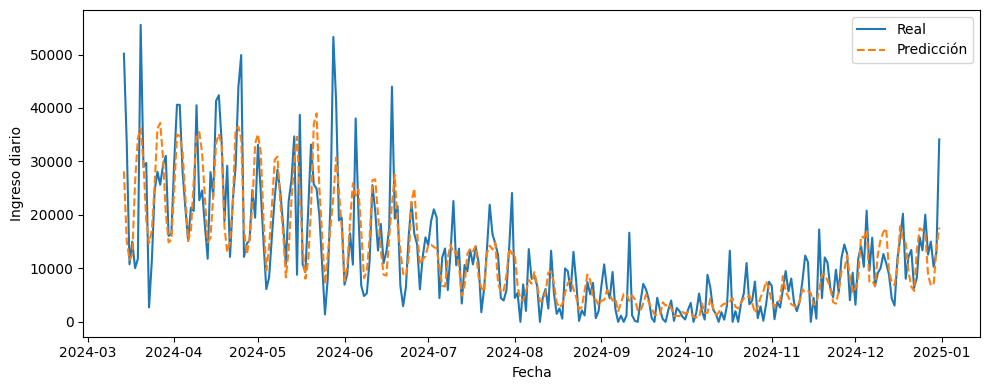

In [8]:
y_pred = model.predict(X_test)
r2   = r2_score(y_test, y_pred)
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

plt.figure(figsize=(10,4))
plt.plot(test['fecha'], y_test, label='Real')
plt.plot(test['fecha'], y_pred, '--', label='Predicción')
plt.xlabel('Fecha'); plt.ylabel('Ingreso diario')
plt.legend(); plt.tight_layout(); plt.show()


In [9]:
import joblib

# 'model' es el RandomForest entrenado
joblib.dump(model, 'rf_diario.pkl')
print("Modelo diario guardado en rf_diario.pkl")


Modelo diario guardado en rf_diario.pkl
